# FixRes: Fixing train-test resolution discrepancy (FixRes: 訓練とテストの解像度の不一致の修正)

**Author:** [Sayak Paul](https://twitter.com/RisingSayak)<br>
**Date created:** 2021/10/08<br>
**Last modified:** 2021/10/10<br>
**Description:** Mitigating resolution discrepancy between training and test sets.

## 序章

ビジョンモデルの学習とテストに同じ入力画像の解像度を使用するのは一般的なことです。
しかし、次のような問題があります。
[Fixing the train-test resolution discrepancy](https://arxiv.org/abs/1906.06423)
(Touvron et al.)で検討されているように、この方法では最適な性能が得られません。
データの補強は、深層ニューラルネットワークの学習プロセスに不可欠な要素です。
視覚モデルでは、学習時にはランダムなサイズの切り抜きを使用し、推論時には中央の切り抜きを使用します。
このため、学習時と推論時に見られる物体のサイズに違いが生じます。
Touvronらが示したように、この不一致を修正することができれば、
モデルの性能を大幅に向上させることができます。

この例では，Touvron et al.が導入した**FixRes**技術を実装し、この矛盾を解消します。

## Imports

In [3]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

import tensorflow_datasets as tfds

tfds.disable_progress_bar()

import matplotlib.pyplot as plt

## Load the `tf_flowers` dataset

In [4]:
train_dataset, val_dataset = tfds.load(
    "tf_flowers", split=["train[:90%]", "train[90%:]"], as_supervised=True
)

num_train = train_dataset.cardinality()
num_val = val_dataset.cardinality()
print(f"Number of training examples: {num_train}")
print(f"Number of validation examples: {num_val}")

Dataset tf_flowers downloaded and prepared to /Users/shogo/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.
Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Number of training examples: 3303
Number of validation examples: 367


## データ前処理ユーティリティ

3つのデータセットを作成します。

1. 解像度を小さくしたデータセット - 128x128
2. 224x224という大きめの解像度を持つ2つのデータセット

大きな解像度のデータセットには異なる拡張変換を適用します。

FixResの考え方は、まず小さい解像度のデータセットでモデルを学習し、次に大きい解像度のデータセットでモデルを微調整するというものです。
このシンプルかつ効果的な方法により、自明ではないパフォーマンスの向上が期待できます。
結果については、[原著論文](https://arxiv.org/abs/1906.06423)をご参照ください。
結果は以下の通りです。

In [5]:
# Reference: https://github.com/facebookresearch/FixRes/blob/main/transforms_v2.py.

batch_size = 128
auto = tf.data.AUTOTUNE
smaller_size = 128
bigger_size = 224

size_for_resizing = int((bigger_size / smaller_size) * bigger_size)
central_crop_layer = layers.CenterCrop(bigger_size, bigger_size)


def preprocess_initial(train, image_size):
    """Initial preprocessing function for training on smaller resolution.

    For training, do random_horizontal_flip -> random_crop.
    For validation, just resize.
    No color-jittering has been used.
    """

    def _pp(image, label, train):
        if train:
            channels = image.shape[-1]
            begin, size, _ = tf.image.sample_distorted_bounding_box(
                tf.shape(image),
                tf.zeros([0, 0, 4], tf.float32),
                area_range=(0.05, 1.0),
                min_object_covered=0,
                use_image_if_no_bounding_boxes=True,
            )
            image = tf.slice(image, begin, size)

            image.set_shape([None, None, channels])
            image = tf.image.resize(image, [image_size, image_size])
            image = tf.image.random_flip_left_right(image)
        else:
            image = tf.image.resize(image, [image_size, image_size])

        return image, label

    return _pp


def preprocess_finetune(image, label, train):
    """Preprocessing function for fine-tuning on a higher resolution.

    For training, resize to a bigger resolution to maintain the ratio ->
        random_horizontal_flip -> center_crop.
    For validation, do the same without any horizontal flipping.
    No color-jittering has been used.
    """
    image = tf.image.resize(image, [size_for_resizing, size_for_resizing])
    if train:
        image = tf.image.random_flip_left_right(image)
    image = central_crop_layer(image[None, ...])[0]

    return image, label


def make_dataset(
    dataset: tf.data.Dataset,
    train: bool,
    image_size: int = smaller_size,
    fixres: bool = True,
    num_parallel_calls=auto,
):
    if image_size not in [smaller_size, bigger_size]:
        raise ValueError(f"{image_size} resolution is not supported.")

    # Determine which preprocessing function we are using.
    if image_size == smaller_size:
        preprocess_func = preprocess_initial(train, image_size)
    elif not fixres and image_size == bigger_size:
        preprocess_func = preprocess_initial(train, image_size)
    else:
        preprocess_func = preprocess_finetune

    if train:
        dataset = dataset.shuffle(batch_size * 10)

    return (
        dataset.map(
            lambda x, y: preprocess_func(x, y, train),
            num_parallel_calls=num_parallel_calls,
        )
        .batch(batch_size)
        .prefetch(num_parallel_calls)
    )

準備しているデータセットの種類に応じて、拡張変換がどのように変化するかに注目してください。

## データセットの準備

In [6]:
initial_train_dataset = make_dataset(train_dataset, train=True, image_size=smaller_size)
initial_val_dataset = make_dataset(val_dataset, train=False, image_size=smaller_size)

finetune_train_dataset = make_dataset(train_dataset, train=True, image_size=bigger_size)
finetune_val_dataset = make_dataset(val_dataset, train=False, image_size=bigger_size)

vanilla_train_dataset = make_dataset(
    train_dataset, train=True, image_size=bigger_size, fixres=False
)
vanilla_val_dataset = make_dataset(
    val_dataset, train=False, image_size=bigger_size, fixres=False
)

## データセットの可視化

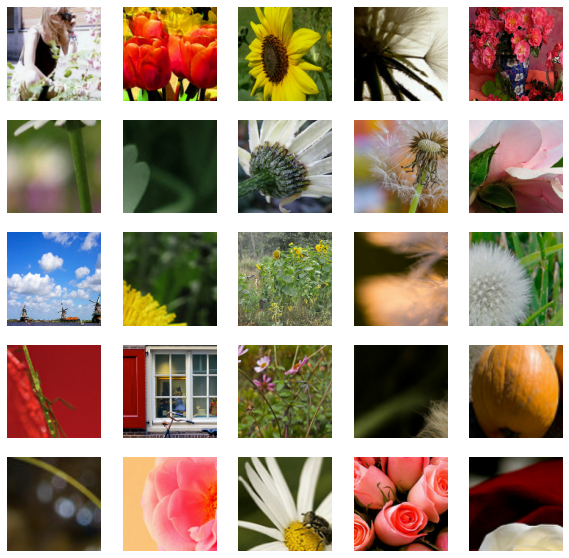

Batch shape: (128, 128, 128, 3).


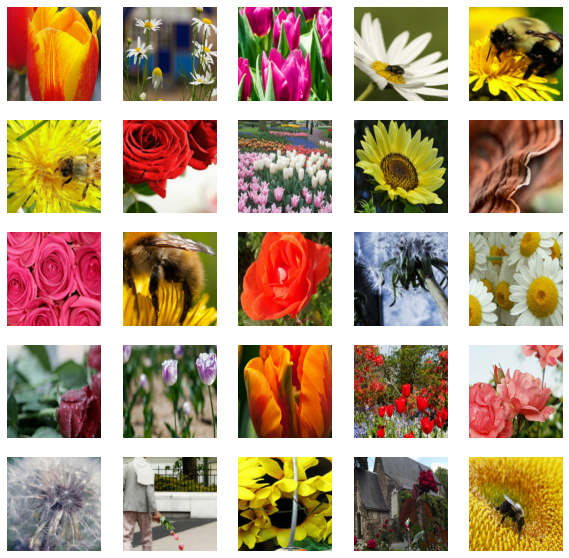

Batch shape: (128, 224, 224, 3).


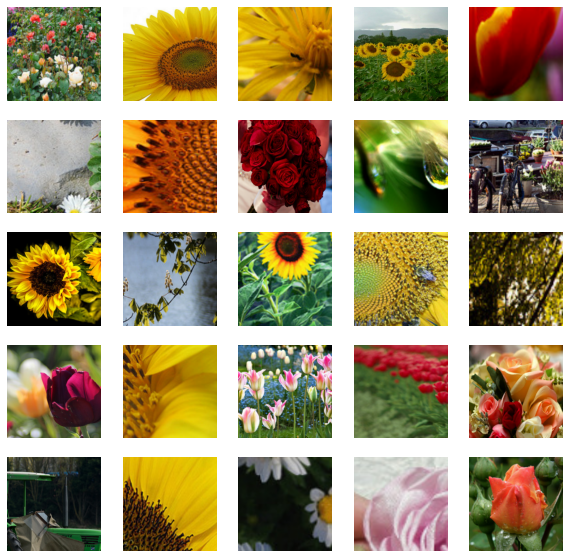

Batch shape: (128, 224, 224, 3).


In [7]:
def visualize_dataset(batch_images):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(batch_images[n].numpy().astype("int"))
        plt.axis("off")
    plt.show()

    print(f"Batch shape: {batch_images.shape}.")


# Smaller resolution.
initial_sample_images, _ = next(iter(initial_train_dataset))
visualize_dataset(initial_sample_images)

# Bigger resolution, only for fine-tuning.
finetune_sample_images, _ = next(iter(finetune_train_dataset))
visualize_dataset(finetune_sample_images)

# Bigger resolution, with the same augmentation transforms as
# the smaller resolution dataset.
vanilla_sample_images, _ = next(iter(vanilla_train_dataset))
visualize_dataset(vanilla_sample_images)

## モデルトレーニングユーティリティ

ResNet50V2の複数のバージョンを学習します。
([He et al.](https://arxiv.org/abs/1603.05027))

1. 解像度の小さいデータセット(128x128)で学習。ゼロからの学習となります。
2. 次に、より大きな解像度（224x224）のデータセットで、1のモデルを微調整します。
3. より大きな解像度のデータセットで、別のResNet50V2を一から学習する。

注意点としては、より大きな解像度のデータセットは、拡張変換の点で異なることです。
トランスフォームが異なります。

In [8]:
def get_training_model(num_classes=5):
    inputs = layers.Input((None, None, 3))
    resnet_base = keras.applications.ResNet50V2(
        include_top=False, weights=None, pooling="avg"
    )
    resnet_base.trainable = True

    x = layers.Rescaling(scale=1.0 / 127.5, offset=-1)(inputs)
    x = resnet_base(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)


def train_and_evaluate(
    model, train_ds, val_ds, epochs, learning_rate=1e-3, use_early_stopping=False
):
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    if use_early_stopping:
        es_callback = keras.callbacks.EarlyStopping(patience=5)
        callbacks = [es_callback]
    else:
        callbacks = None

    model.fit(
        train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks,
    )

    _, accuracy = model.evaluate(val_ds)
    print(f"Top-1 accuracy on the validation set: {accuracy*100:.2f}%.")
    return model

## 実験1：128x128でトレーニングした後、224x224で微調整を行う

In [9]:
epochs = 30

smaller_res_model = get_training_model()
smaller_res_model = train_and_evaluate(
    smaller_res_model, initial_train_dataset, initial_val_dataset, epochs
)

Epoch 1/30
26/26 [==============================] - 40s 1s/step - loss: 1.5088 - accuracy: 0.4320 - val_loss: 1873.5170 - val_accuracy: 0.2071
Epoch 2/30
26/26 [==============================] - 33s 1s/step - loss: 1.1779 - accuracy: 0.5298 - val_loss: 63.1758 - val_accuracy: 0.1962
Epoch 3/30
26/26 [==============================] - 32s 1s/step - loss: 1.0985 - accuracy: 0.5707 - val_loss: 3.0070 - val_accuracy: 0.2888
Epoch 4/30
26/26 [==============================] - 33s 1s/step - loss: 1.0606 - accuracy: 0.5873 - val_loss: 7.0175 - val_accuracy: 0.2207
Epoch 5/30
26/26 [==============================] - 33s 1s/step - loss: 1.0298 - accuracy: 0.6085 - val_loss: 1.8199 - val_accuracy: 0.3515
Epoch 6/30
26/26 [==============================] - 33s 1s/step - loss: 1.0030 - accuracy: 0.6185 - val_loss: 1.7726 - val_accuracy: 0.3106
Epoch 7/30
26/26 [==============================] - 33s 1s/step - loss: 1.0193 - accuracy: 0.6140 - val_loss: 1.3303 - val_accuracy: 0.4877
Epoch 8/30
26/26

### 最後の「バッチ・ノーマライゼーション」レイヤーを除くすべてのレイヤーを凍らせる

微調整のために、2つのレイヤーのみを学習します。

* 最終バッチ正規化 ([Ioffe et al.](https://arxiv.org/abs/1502.03167)) 層。
* 分類層です。

最終バッチ正規化層は、グローバル平均プーリング層の前の活性化統計の変化を補うために、凍結を解除しています。
グローバルアベレージプーリング層の前の活性化統計の変化を補うために、最後のバッチノーマライゼーション層を凍結解除しています。で示したように
[論文](https://arxiv.org/abs/1906.06423)にあるように、最後のバッチ正規化層の凍結解除で十分です。

Kerasでのモデルの微調整に関する包括的なガイドは、以下を参照してください。
[このチュートリアル](https://keras.io/guides/transfer_learning/)を参照してください。

In [10]:
for layer in smaller_res_model.layers[2].layers:
    layer.trainable = False

smaller_res_model.layers[2].get_layer("post_bn").trainable = True

epochs = 10

# Use a lower learning rate during fine-tuning.
bigger_res_model = train_and_evaluate(
    smaller_res_model,
    finetune_train_dataset,
    finetune_val_dataset,
    epochs,
    learning_rate=1e-4,
)

Epoch 1/10
26/26 [==============================] - 37s 1s/step - loss: 0.7293 - accuracy: 0.7769 - val_loss: 0.7798 - val_accuracy: 0.7330
Epoch 2/10
26/26 [==============================] - 33s 1s/step - loss: 0.6759 - accuracy: 0.7805 - val_loss: 0.7000 - val_accuracy: 0.7384
Epoch 3/10
26/26 [==============================] - 33s 1s/step - loss: 0.6619 - accuracy: 0.7893 - val_loss: 0.6716 - val_accuracy: 0.7520
Epoch 4/10
26/26 [==============================] - 33s 1s/step - loss: 0.6503 - accuracy: 0.7887 - val_loss: 0.6520 - val_accuracy: 0.7602
Epoch 5/10
26/26 [==============================] - 33s 1s/step - loss: 0.6409 - accuracy: 0.7956 - val_loss: 0.6398 - val_accuracy: 0.7602
Epoch 6/10
26/26 [==============================] - 33s 1s/step - loss: 0.6403 - accuracy: 0.7978 - val_loss: 0.6271 - val_accuracy: 0.7602
Epoch 7/10
26/26 [==============================] - 33s 1s/step - loss: 0.6197 - accuracy: 0.8014 - val_loss: 0.6223 - val_accuracy: 0.7575
Epoch 8/10
26/26 [==

## 実験2: 224x224の解像度のモデルをゼロからトレーニングする

次に、より大きな解像度のデータセットを使って、別のモデルをゼロからトレーニングします。このデータセットでは
このデータセットで使われている拡張変換は、以前とは異なります。

In [11]:
epochs = 30

vanilla_bigger_res_model = get_training_model()
vanilla_bigger_res_model = train_and_evaluate(
    vanilla_bigger_res_model, vanilla_train_dataset, vanilla_val_dataset, epochs
)

Epoch 1/30
26/26 [==============================] - 181s 7s/step - loss: 1.5694 - accuracy: 0.4323 - val_loss: 18695.0293 - val_accuracy: 0.1907
Epoch 2/30
26/26 [==============================] - 184s 7s/step - loss: 1.1525 - accuracy: 0.5419 - val_loss: 159.9468 - val_accuracy: 0.2316
Epoch 3/30
26/26 [==============================] - 183s 7s/step - loss: 1.0747 - accuracy: 0.5752 - val_loss: 17.6134 - val_accuracy: 0.1717
Epoch 4/30
26/26 [==============================] - 188s 7s/step - loss: 1.0570 - accuracy: 0.5992 - val_loss: 6.7909 - val_accuracy: 0.3243
Epoch 5/30
26/26 [==============================] - 192s 7s/step - loss: 1.0094 - accuracy: 0.6294 - val_loss: 2.8554 - val_accuracy: 0.4142
Epoch 6/30
26/26 [==============================] - 180s 7s/step - loss: 0.9693 - accuracy: 0.6415 - val_loss: 1.4688 - val_accuracy: 0.4387
Epoch 7/30
26/26 [==============================] - 184s 7s/step - loss: 0.9772 - accuracy: 0.6276 - val_loss: 2.9377 - val_accuracy: 0.4714
Epoch 

上記のセルからわかるように、FixResはより良いパフォーマンスをもたらします。また
FixResのもう1つの利点は、総学習時間の短縮とGPUメモリ使用量の削減です。
FixResはモデルに依存しないため、どのような画像分類モデルにも使用でき、パフォーマンスの向上が期待できます。

詳しい結果は
[こちら](https://tensorboard.dev/experiment/BQOg28w0TlmvuJYeqsVntw)
同じコードを異なるランダムシードで実行して得られた結果です。